
# Finite Expectation Maximization in incremental processing


This section covers the transition to incremental learning (aka. online learning) which allows
to process one data point at a time (without storing previous examples).

## Implementation

In addition to the formulas in [Kimura11], we express the maximization steps for the model parameters in terms of sufficient statistics. That way, the maximization step can be unified for both approaches. In the end,
we want an implementation where batch and online learning can be selected by a parameter.



$$ \begin{array}{rcll}
S(x,y) &=& \big(\underbrace{\delta_1(x), \ldots, \delta_k(x)}_{=:a_{1:k}}, \underbrace{y\delta_1(x), \ldots, y\delta_k(x)}_{=:b_{1:k}}, \underbrace{yy^T\delta_1(x), \ldots, yy^T\delta_k(x)}_{=:c_{1:k}} \big)\\
S^{(t)} &=& (1-\gamma_t)S^{(t-1)} + \gamma_t \mathbb E\left(S(x,y)|y_t,\Phi^{(t-1}\right) \\
\gamma_t &=& t^{-\alpha}, & 0.5<\alpha<1.0 \text{ (in practice) }\\
\\
S^{0,(t)}_i  & = & (1-\gamma_t)a_i^{(t-1)} + \gamma_t  \text{Pr}(x_t=i | y_t, \Phi^{(j-1)}) \\
& \approx & \sum_{t=1}^T \mathbb E \left[  \delta_i | y_{1:T}, \Phi^(j-1) \right] \\
&=& \sum_{t=1}^T \text{Pr}(x_t=i | y_t, \Phi^{(j-1)})\\
&=:& a_i^{(t)}\\
S^{1,(t)}_i  &=& (1-\gamma_t)b_i^{(t-1)} + \gamma_t y_t \text{Pr}(x_t=i | y_t, \Phi^{(j-1)}) \\
& \approx & \sum_{t=1}^T \mathbb E \left[ y_t \delta_i | y_{1:T}, \Phi^(j-1) \right] \\
&=& \sum_{t=1}^T y_t \text{Pr}(x_t=i | y_t, \Phi^{(j-1)})\\ 
&=:& b_i^{(t)}\\
%
S^{2,(t)}_i &=& (1-\gamma_t)c_i^{(t-1)} + \gamma_t y_t y_t^T\text{Pr}(x_t=i | y_t, \Phi^{(j-1)}) \\
& \approx & \sum_{t=1}^T \mathbb E \left[ y_t y_t^T \delta_i | y_{1:T}, \Phi^(j-1) \right] \\
&=& \sum_{t=1}^T y_t y_t^T\text{Pr}(x_t=i | y_t, \Phi^{(j-1)})\\ 
&=:& c_i^{(t)}\\
\\
\end{array}$$

$$ \begin{array}{rcll}
T &\stackrel{!}{=}& \sum^t_{t=1} \sum_{i=1}^k Pr(x_t=i | y_t, \Phi^{(j-1)}) = T, & \text{ ($Pr(x_t)$ sum to 1)}  \\
\\
    ~\pi_i^{(j)} 
    &=& \frac{\sum^t_{t=1} \mathbb E[\delta_i(x_t)|y_{1:T},\Phi^{(j-1)}]} {T} 
    = \frac{\sum^t_{t=1} Pr(x_t=i | y_t, \Phi^{(j-1)})}{T} \\
    &=& \frac{a_i^{(t)}}{\sum_{j=1}^k a_j^{(t)}} \approx \frac{S_i^{0,(t)}}{\sum_{j=1}^k S_j^{0,(t)}} \\
%
    ~m_i^{(j)} 
    &=& \frac{\sum^t_{t=1} \mathbb E[y_t \cdot \delta_i(x_t)|y_{1:T},\Phi^{(j-1)}]} {\sum^t_{t=1} \mathbb E[\delta_i(x_t)|y_{1:T},\Phi^{(j-1)}]} 
    = \frac{\sum^t_{t=1} y_t \cdot Pr(x_t=i | y_t, \Phi^{(j-1)})}{\sum^t_{t=1} Pr(x_t=i | y_t, \Phi^{(j-1)})}\\
    &=& \frac{b_i^{(t)}}{a_i^{(t)}} \approx \frac{S_i^{1,(t)}}{ S_i^{0,(t)}} \\
%
    \Sigma_i^{(j)}
    &=& \frac{\sum^t_{t=1} \mathbb E[y_t \cdot y_t^T \cdot \delta_i(x_t)|y_{1:T},\Phi^{(j-1)}]} 
    {\sum^t_{t=1} \mathbb E[\delta_i(x_t)|y_{1:T},\Phi^{(j-1)}]} - m_i^{(j)} \cdot m_i^{(j)T} \\
    &=& \frac{\sum^t_{t=1} y_t\cdot y_t^T \cdot Pr(x_t=i | y_t, \Phi^{(j-1)})}{\sum^t_{t=1} Pr(x_t=i | y_t, \Phi^{(j-1)})} - m_i^{(j)}\cdot m_i^{(j)T}\\
    &=& \frac{c_i^{(t)}}{a_i^{(t)}} - m_i^{(t)} m_i^{(t)T} \approx \frac{S_i^{2,(t)}}{ S_i^{0,(t)}}  - m_i^{(t)} m_i^{(t)T} \\
\end{array}$$

We will use only the variables $S^0,S^1, S^2$ in the implementation referring to both the actual expectation values and their estimates in online learning.

About equivalency of using the sufficient statistics in batch mode. The following code can be used to assure the similarity:


```python
means2 = (
    np.sum( data[:,np.newaxis,:] * responsibilities[:,:,np.newaxis], axis=0) 
    / (weights[:,np.newaxis] * n_samples)
)
covs2 = (
    np.sum(
        np.einsum('Ti,Tj->Tij', data, data)[:,np.newaxis,:,:] * 
        responsibilities[:,:,np.newaxis,np.newaxis] /
        (weights[:,np.newaxis,np.newaxis] * n_samples), # n_samples x n_components x n_dim x n_dim
        axis=0
    ) -
    np.einsum('ki,kj->kij', means2, means2) # n_components x n_dim x n_dim
) + self.cached_regularization[np.newaxis,:,:]

means = self.sufficient_statistics[1] / self.sufficient_statistics[0][:, np.newaxis]
covs = (
    self.sufficient_statistics[2] / self.sufficient_statistics[0][:, np.newaxis, np.newaxis]
    - np.einsum('ki,kj->kij', means, means)
) + self.cached_regularization[np.newaxis,:,:]


logger.info(f"Difference means: {((means - means2)**2).mean()}")
logger.info(f"Difference covs: {((covs - covs2)**2).mean()}") #practically zero in batch mode!
```

### Numerical stability

It is often encountered that covariances become singular (and not symmetric, positive definite). This happens when only one single data point contributes significantly to its computation (as stated here [Bishop]() and [here](). A simple means is to ad a regularization parameter to the covariances (e.g., add $1\cdot 10^{-6}$ to the diagonal) which prevents numerical errors (this is in fact what [scipy]() does, see the parameter `rcond`). 

In later versions, the minimum Eigenvalue (that is, the smallest extend of one Gaussian elipsoids main axis) is used to detect a degenerated component.

### Initialization

Given an existing model (learned in batch or more important, a random initialization), we can compute the sufficient statistics by assuming a number $T$ previously observed examples: 

$$ \begin{array}{rcll}
    S_i^{0,(0)}&=& \pi_i^{(0)} \cdot T \\
    S_i^{1,(0)} &=& S_i^{0,(0)} \cdot m_i^{(j)} \\
    S_i^{2,(0)} &=& S_i^{0,(0)} \cdot \left(\Sigma_i^{0)} + m_i^{(0)} m_i^{(0)T}\right)\\
\end{array}$$

## Data acquisition

The next plot shows the influence of the decay / learning factor ($\alpha$ in the paper). Then, data generation is shown.



Text(0.5, 1.0, 'Learn rate $\\gamma_t$')

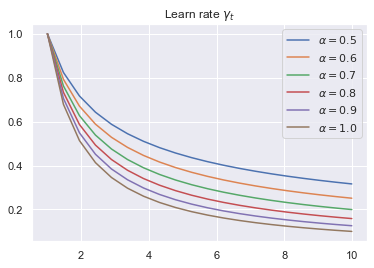

In [4]:
import seaborn as sns

from matplotlib import pyplot as plt
sns.set()

import numpy as np
%matplotlib inline

x = np.linspace(1,10,20)
plt.plot(x, x**(-0.5),label="$\\alpha=0.5$")
plt.plot(x, x**(-0.6),label="$\\alpha=0.6$")
plt.plot(x, x**(-0.7),label="$\\alpha=0.7$")
plt.plot(x, x**(-0.8),label="$\\alpha=0.8$")
plt.plot(x, x**(-0.9),label="$\\alpha=0.9$")
plt.plot(x, x**(-1.0),label="$\\alpha=1.0$")
plt.legend()
plt.title('Learn rate $\\gamma_t$')

{0: 22, 1: 20, 2: 15, 3: 17, 4: 26}


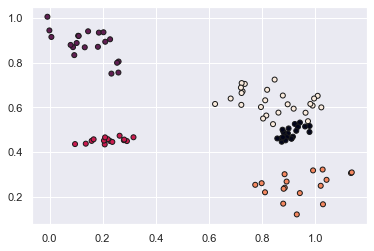

In [18]:
from kuberspatiotemporal.tools import make_gmm

n_clusters=5
X,_, y,_ = make_gmm(100, n_clusters=n_clusters)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

In [15]:
from typing import List
import logging
from scipy.stats import multivariate_normal as mvn
from sklearn.datasets import make_spd_matrix
import numpy as np
from numpy.random import random_sample
import attr
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys

from kuberspatiotemporal.tools import check_spd, make_ellipses

%matplotlib inline

# Always useful: https://stackoverflow.com/a/44401529
logging.basicConfig(format='[%(funcName)s:%(lineno)d] %(message)s')
logger = logging.getLogger(__name__)

logger.setLevel(logging.DEBUG)

#######################
# Additions to tools.py
#######################

def check_singular(x, tol = 1/sys.float_info.epsilon):
    is_singular =  np.linalg.cond(x) > tol
    if is_singular:
        logger.warning("Found singular matrix:\n%s\ncond: %f>%f",
                       x, np.linalg.cond(x), tol)
    return is_singular

def repr_list_ndarray(x: np.ndarray) -> str:
    return f"`list of length {len(x)}, elements of shape {np.asarray(x).shape[1:]}`"

def make_ellipses(gmm: 'GaussianMixtureModel', ax):
    """Shamelessly stolen from 
    https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html"""
    
    colors = ['navy', 'turquoise', 'darkorange','firebrick',
              'yellowgreen', 'mediumorchid','slateblue',
              'darkcyan','gold','mediumpurple','navajowhite']

    for n, color in enumerate(colors):
        
        if n==gmm.n_components:
            break
        
        covariances = gmm.covs[n]
        

        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means[n], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
    
##################
# dpm.py
##################

@attr.s
class GaussianMixtureModel:
    # public attributes
    n_components: int = attr.ib()
    n_dim: int = attr.ib(default=3)
    alpha: float = attr.ib(default=0.75)
    start_maximimization: int = attr.ib(default=5)
        
    # Internal state variables
    counter: int = attr.ib(default=0) # This is intended for resuming
    # TODO consider the model to be numpy arrays instead of lists
    weights: List[float] = attr.ib(factory=list, repr=lambda x: f"`list of length {len(x)}`")
    means: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
    covs: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
    sufficient_statistics: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
        
    def __attrs_post_init__(self):
        if not self.weights:
            rand = np.random.random((self.n_components,))
            self.weights = (rand / np.sum(rand)).tolist()
        if not self.means:
            self.means = [ np.random.random_sample(( self.n_dim,)) 
                          for i in range(self.n_components)]
        if not self.covs:
            self.covs = [ make_spd_matrix(self.n_dim) * 0.01
                         for i in range(self.n_components)]
        # TODO: check if S^(0) can be zero ... actually (1 - 1^{-alpha}) is always! zero!
        if not self.sufficient_statistics:
            self.sufficient_statistics = [
                np.zeros((self.n_components,)),
                np.zeros((self.n_components,self.n_dim)),
                np.zeros((self.n_components,self.n_dim,self.n_dim))
            ]
            
    
    # TODO Avoid working with loops. But mvn needs to be rewritten
    def expect(self, data: np.ndarray) -> List[List[float]]:
        """Returns the responsibilities."""

        for i in self.covs:
            if check_singular(i,1e11):
                logger.error('Found singular matrix')
                # raise ArithmeticError(f"Singular covariance matrix:\n{i}")
                # Todo think about how to handle this case.
                
                
        responsibilities = []
        for t in range(data.shape[0]):
            weights = np.asarray(self.weights)
            try:
                denominator = np.sum( [self.weights[i] * mvn.pdf(data[t], 
                                                              self.means[i], 
                                                              self.covs[i]) 
                                       for i in range(self.n_components)] )


                nominators = [self.weights[i] / denominator * mvn.pdf(data[t], 
                                                                   self.means[i], 
                                                                   self.covs[i]) 
                              for i in range(self.n_components)]
            except np.linalg.LinAlgError as e:
                logger.exception("Singular matrix:\n%s,%s,\n%s",
                                 e, [np.linalg.cond(x) for x in self.covs], 
                                 1/sys.float_info.epsilon )

            responsibilities.append(nominators)
        
        return responsibilities 
    
    def maximize(self):
        weights = self.sufficient_statistics[0] / np.sum(self.sufficient_statistics[0])
        means = self.sufficient_statistics[1] / self.sufficient_statistics[0][:,np.newaxis]
        covs = (
            self.sufficient_statistics[2] /  self.sufficient_statistics[0][:,np.newaxis,np.newaxis]
            - np.einsum('ki,kj->kij', means, means)
        )

        logger.debug(weights)
        logger.debug(means)
        logger.debug(covs)

        assert weights.shape == (self.n_components,)
        assert means.shape == (self.n_components, self.n_dim)
        assert covs.shape == (self.n_components, self.n_dim, self.n_dim)

        self.weights = weights.tolist()
        self.means = [i for i in means]
        self.covs = [i for i in covs]


        for i,c in enumerate(self.covs):
            if not check_spd(c):
                logger.info("Sufficient statistics for component %d: %s", i,
                            [j[i] for j in self.sufficient_statistics])
                raise ArithmeticError("Encountered non-SPD matrix")
        
    def batch(self, data: np.ndarray):
        # Compute the sufficient statistics 
        # Instead of regular EM. Then the maximization is the same for batch and incremental
        




        n_samples = data.shape[0]

        responsibilities = np.asarray(self.expect(data)) 
        assert responsibilities.shape == (n_samples, self.n_components)


        self.sufficient_statistics[0] = np.sum(
            responsibilities, # (n_samples, n_components)
            axis=0
        )

        self.sufficient_statistics[1] = np.sum(
            responsibilities[:,:,np.newaxis] * data[:,np.newaxis,:], # (n_samples, n_components, n_dim)
            axis=0
        )

        self.sufficient_statistics[2] = np.sum(
            responsibilities[:,:,np.newaxis,np.newaxis] * 
            np.einsum('Ti,Tj->Tij',data,data)[:,np.newaxis,:,:], # (n_samples, n_components, n_dim, n_dim)
            axis=0
        ) 

        assert self.sufficient_statistics[0].shape == (self.n_components,)
        assert self.sufficient_statistics[1].shape == (self.n_components, self.n_dim)
        assert self.sufficient_statistics[2].shape == (self.n_components, self.n_dim, self.n_dim)

        self.maximize()
        
        self.counter = n_samples
    
    def incremental(self, data: np.ndarray):
        
        
        for t,sample in enumerate(data):
            self.counter += 1
            logger.debug('Observing sample %d\n%s', self.counter, sample)
            
            responsibilities = np.asarray(self.expect(sample.reshape(1,-1))).reshape(-1)

            logger.debug("Resp. %s", responsibilities.shape) # (1, n_components)
            assert responsibilities.shape == (self.n_components,)
        
            rate = (self.counter+1)**(-self.alpha)
            logger.debug('Rate at iteration %d: %f, (1-rate): %f, t: %d, a: %f', t, rate, (1-rate), t, self.alpha)
        
        
            for i in self.sufficient_statistics:
                i *= (1-rate)
            
            self.sufficient_statistics[0] += (
                rate * responsibilities
            )
            
            self.sufficient_statistics[1] += (
                rate * responsibilities[:,np.newaxis] * sample[np.newaxis,:]
            )
            
            self.sufficient_statistics[2] += (
                rate * responsibilities[:,np.newaxis,np.newaxis] * 
                np.einsum('i,j->ij',sample,sample)[np.newaxis,:,:]
            )
            
            logger.debug(self.sufficient_statistics)
            
            assert self.sufficient_statistics[0].shape == (self.n_components,)
            assert self.sufficient_statistics[1].shape == (self.n_components, self.n_dim)
            assert self.sufficient_statistics[2].shape == (self.n_components, self.n_dim, self.n_dim)

            if self.counter > self.start_maximimization:
                self.maximize()

    def fit(self, data: np.ndarray, n_iterations=100, online=False):
        if len(data.shape) != 2:
            raise ValueError(f"Wrong input dimensions (at least 2D)")
            
        if data.shape[1] != self.n_dim:
            raise ValueError(f"Wrong input dimensions {data.shape[1]} != {self.n_dim} ")

        logger.info("Learning %d samples (%s)", data.shape[0], 
                    "Online" if online else "Batch")

        for i in range(n_iterations):
            if i % 10 == 0:
                logger.info('Step %d/%d', i, n_iterations)
            if online:
                self.incremental(data)
            else:
                self.batch(data)

    def get_logger(self):
        return logger
            
            

Observation: If $(1-\gamma_t) = 0$, then $\frac{b_i^{(t)}}{a_i^{(t)}}$ is simply $y_t$! Then all $m_i$ are equal, and the covariances are zero. Which makes sense given that there is only one single point. 

## Experiment

The following script performs an experiment (could be use for parameterizable experiments).

In [13]:
def run_experiment(counter: int, batch_iterations=200, online_iterations=30):
    gmm = GaussianMixtureModel(n_clusters, n_dim=2,start_maximimization=10)
    gmm.get_logger().setLevel(logging.INFO)
    # gmm.get_logger().setLevel(logging.DEBUG)
    np.seterr(all='print') 

    # f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex='col', sharey='row',figsize=(18, 18))
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(18, 18))

    ##########
    # Online 
    
    if counter > 0:
        gmm.fit(X[:counter,:], online=False, n_iterations=batch_iterations)

        make_ellipses(gmm, ax1)

        means = np.asarray(gmm.means)
        ax1.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                    s=50, edgecolor='k')
    ax1.scatter(X[:counter, 0], X[:counter, 1], marker='o', c=y[:counter],
            s=25, edgecolor='k')
    ax1.set_title(f"Batch learning ({batch_iterations} iterations, {counter} samples).")

    ##########
    # Online 

    gmm.get_logger().setLevel(logging.INFO)

    gmm.fit(X[counter:,:],online=True, n_iterations=online_iterations)

    make_ellipses(gmm, ax2)

    ax2.scatter(X[counter:, 0], X[counter:, 1], marker='o', c=y[counter:],
                s=25, edgecolor='k')

    means = np.asarray(gmm.means)
    ax2.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    ax2.set_title(f"Online learning ({batch_iterations} iterations, {X.shape[0]-counter} samples).")
    

    ####################
    # Show all samples

    make_ellipses(gmm, ax3)

    ax3.scatter(X[:, 0], X[:, 1], marker='o', c=y,
                s=25, edgecolor='k')

    means = np.asarray(gmm.means)
    ax3.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    ax3.set_title(f"All data.")
    

[fit:251] Learning 50 samples (Batch)
[fit:251] Learning 50 samples (Online)
[fit:255] Step 0/30
[fit:255] Step 10/30
[fit:255] Step 20/30


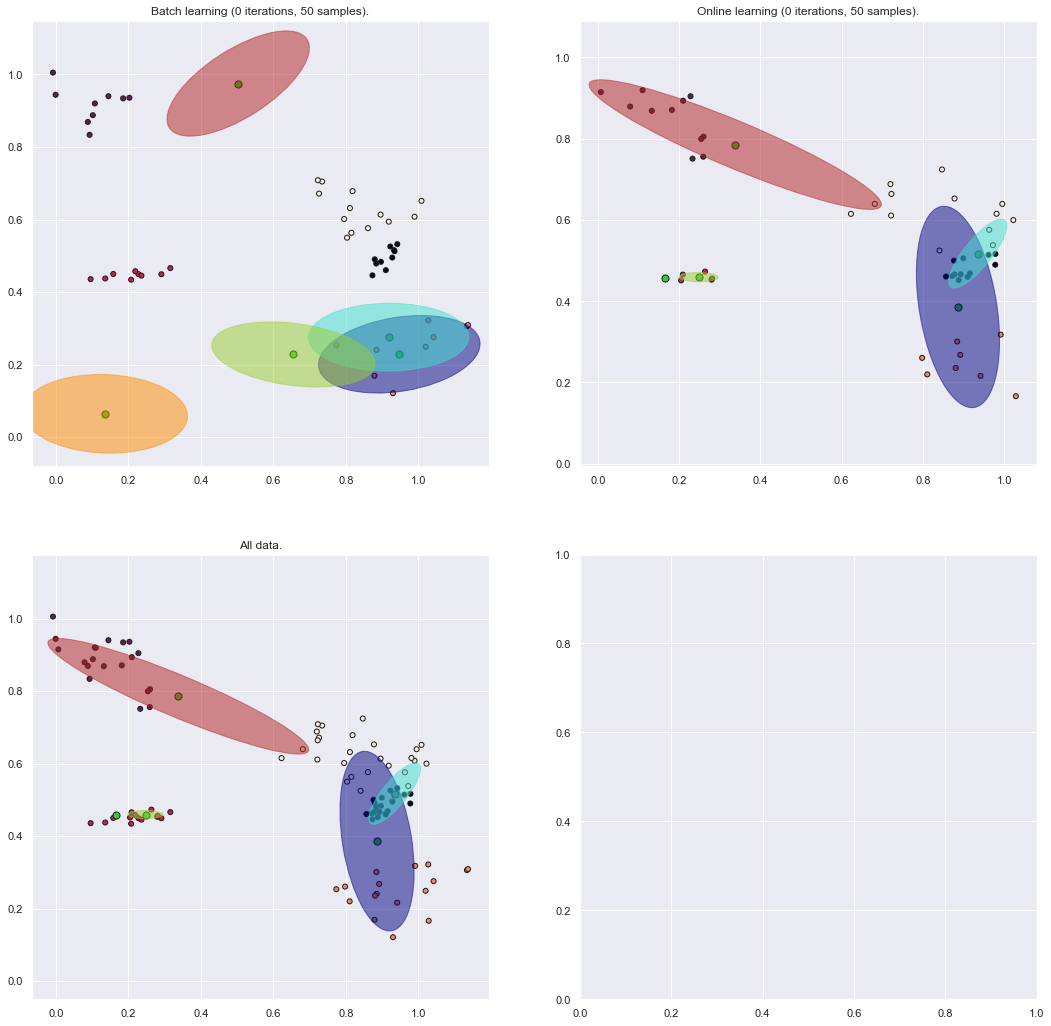

In [24]:
run_experiment(50, batch_iterations=0)